# Assignment 2 (Part b) : SVMs
## Qeustion 1 : Binary Classification 

* In this Part I have implmented SVM using CVXOPT module and used qp solvers of that modules which solves following optimization problem
$$\min_{x}\frac{1}{2} x^{T}Px + q^{T}x  \\\ \textrm{s.t.} Gx \preceq h \\\ \textrm{and}\quad Ax = b $$

* Here in soft margin SVM our optimization problem is:

$$ \max_{\alpha_i} \sum_{m} \alpha_i - \frac{1}{2} \sum_{i,j = 1}^{m} \alpha_i \alpha_j y_i y_j\  K\lt x_i,x_j\gt \\\ = \min_{\alpha_i} \frac{1}{2} \sum_{i,j = 1}^{m} \alpha_i \alpha_j y_i y_j\  K\lt x_i,x_j\gt - \sum_{m} \alpha_i 
$$

* Here in $K\lt x_i, x_j \gt$ is kernel value between $x_i$ and $x_j$. I have create kernel matrix of size mxm for training dataset in whihc $(i,j)^{th}$ entry will represent kernel value between $i^{th}$ and $j^{th}$ datapoint. Therefore for linear kernel $K=XX^T$ and for gaussain kernel we need to find $K<x_i, x_j> = \exp({-\gamma*||x_i-x_j||^2})$

* Now finding P,q,G,h,A and b for our optimization problem that we can pass in the qp solver of CVXOPT. 

$$  x^T=[\alpha_1,\alpha_2,...,\alpha_m]_{m}$$
\
$$P=YY^T K, \textrm{where} K=XX^T \textrm{in case of linear kernel}$$ 


$$  q^T=[-1,-1,-1...-1]_{1\times m}$$

$$G = \begin{bmatrix}
-1& & & & &   \\
 & -1 & &  &        &  \\
 &  & \ddots &  &  &    \\
   &  &  & \ddots &  &  \\
  &        & & & \ddots & \\
 &       &        &      &       & -1\\
 1& & & & &   \\
 & 1 & &  &        &  \\
 &  & \ddots &  &  &    \\
   &  &  & \ddots &  &  \\
  &        & & & \ddots & \\
 &       &        &      &       & 1
\end{bmatrix}_{2m\times m}$$

$$h = \begin{bmatrix}
0\\
0\\
\vdots\\
0\\
C\\
C\\
\vdots\\
C
\end{bmatrix}_{2m \times 1}$$\
$$A = Y^T$$
$$b = [0]$$

<hr>

* So now using this optimization problem solvers we have implemnted binary classification model in Question 1 and multiclass classification model using one-vs-one stretergy in next question. 


* All the experiments in this assignment were ran in google colab with 35 GB Ram and 40 core machine.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm import tqdm
from time import time
import math
from cvxopt import solvers, matrix

from scipy.spatial.distance import cdist

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from itertools import combinations 

from joblib import Parallel, delayed
import multiprocessing

* Loading the data for class 2 and 3 as my entry number is 2019mcs2562

In [0]:
def getData(train, test, val, class1=2, class2=3):
    '''
    This method returns X and Y of Train, Test and validation dataset having output labels= class1 or class2
    '''
    #Slicing data where y=class1 or class2
    train = train[np.logical_or(train[:,-1]==class1, train[:,-1]==class2)] 
    val = val[np.logical_or(val[:,-1]==class1, val[:,-1]==class2)] 
    test = test[np.logical_or(test[:,-1]==class1, test[:,-1]==class2)] 

    #Scaling X and mapping class1 to -1 and class2 to 1 to return Yi
    X_train = train[:,:-1]/255
    Y_train = train[:,-1]
    Y_train = np.array([-1 if i==class1 else 1 for i in Y_train], dtype=int).reshape((Y_train.shape[0],1))

    X_val = val[:,:-1]/255
    Y_val = val[:,-1]
    Y_val = np.array([-1 if i==class1 else 1 for i in Y_val], dtype=int).reshape((Y_val.shape[0],1))

    X_test = test[:,:-1]/255
    Y_test = test[:,-1]
    Y_test = np.array([-1 if i==class1 else 1 for i in Y_test], dtype=int).reshape((Y_test.shape[0],1))
    
    return (X_train, Y_train, X_val, Y_val, X_test, Y_test)

#Loading Data-sets
# train = pd.read_csv('/content/drive/My Drive/ML/Assignment2Data/train.csv', header=None).to_numpy()
# val = pd.read_csv('/content/drive/My Drive/ML/Assignment2Data/val.csv', header=None).to_numpy()
# test = pd.read_csv('/content/drive/My Drive/ML/Assignment2Data/test.csv', header=None).to_numpy()
train = pd.read_csv('./data/train.csv', header=None).to_numpy()
val = pd.read_csv('./data/val.csv', header=None).to_numpy()
test = pd.read_csv('./data/test.csv', header=None).to_numpy()



#Getting train, validation and test dataset for class labels 2 and 3
(X_train, Y_train, X_val, Y_val, X_test, Y_test) = getData(train, test, val, class1=2, class2=3)

#Getting whole dataset that will be used in question 2(X's are scaled here)
X_train_whole = train[:,:-1]/255
Y_train_whole = train[:,-1].ravel()
Y_train_whole = Y_train_whole.astype(int)

X_val_whole = val[:,:-1]/255
Y_val_whole = val[:,-1].ravel()
Y_val_whole = Y_val_whole.astype(int)

X_test_whole = test[:,:-1]/255
Y_test_whole = test[:,-1].ravel()
Y_test_whole = Y_test_whole.astype(int)

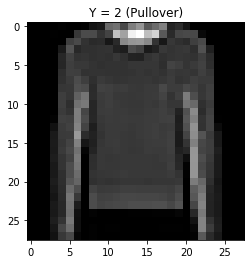

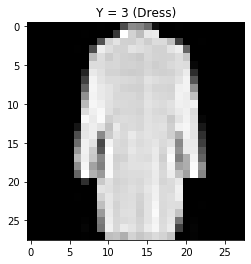

In [4]:
#Showing class = 2(Pullover) and class = 3(Dress) images 
plt.imshow(X_train[np.where(Y_train.ravel() == -1)][0].reshape((28,28)), cmap='gray')
plt.title('Y = 2 (Pullover)')
plt.show()
plt.imshow(X_train[np.where(Y_train.ravel() == 1)][0].reshape((28,28)), cmap='gray')
plt.title('Y = 3 (Dress)')
plt.show()

## Question 1(a) : Implementing Linear SVM

In [0]:
class SVM:
    '''
    This class provides implementation of SVM.
    
    **************
    Parameters:
    C=1 : Regularization parameter (Defalts 1.0)
    threshold=1e-5 : Threshold for alphas i.e. alpha values below this will be treated as 0 (Defalts 1e-5)
    kernel='kernel' : Type of kernel you want to use ('linear' or 'rbf')
    gamma=0.05 : Hyperparameter for rbf kernel
    showTime=True : Boolean to show time taken to fit
    silentCVXOPT=False : Supress the output that CVXopt generates while solving optimization problem 
    **************
    
    **************
    Attributes:
    
    alphas : array of size m
    nSV : Number of support vectors
    SV_indices : indices of support vectors in alphas and in X_train(size=nSV)
    SV : support vectors (size=(m,n))
    SV_y : output label corrosponding to every support vectors (size=m)
    
    
    **************
    '''
    __slots__=['C', 'threshold', 'kernel', 'gamma', 'showTime', 'silentCVXOPT', 'alphas', 'nSV', 'SV_indices', 'SV_y', 'SV', 'w', 'b']

    def __init__(self, C=1, threshold=1e-5, kernel='linear', gamma=0.05, showTime=True, silentCVXOPT = False):
        self.C = C
        self.threshold = threshold
        self.kernel = kernel
        self.gamma = gamma
        self.showTime = showTime
        self.silentCVXOPT = silentCVXOPT
    
    def _getRBFKernelMat(self, X, gamma = 0.05):
        '''Returns rbf kernel matrix for the given data X'''
        return np.exp(-gamma*(cdist(X,X,'euclidean')**2))
    
    def fit(self, X_train, Y_train):
        '''
        This method trains SVM model and stores corrosponding parameters
        
        Important : Y should be mapped to -1 aand 1 only
        '''
        t0 = time()
        
        if self.kernel=='linear':
            P = Y_train.dot(Y_train.T) * (X_train.dot(X_train.T))
        elif self.kernel=='rbf':
            K = self._getRBFKernelMat(X_train, self.gamma)
            P = Y_train.dot(Y_train.T) * (K)
        P=matrix(P,tc='d')

        q = -np.ones(X_train.shape[0])
        q=matrix(q,tc='d')

        G = np.vstack((-np.identity(X_train.shape[0]), np.identity(X_train.shape[0])))
        G=matrix(G,tc='d')

        h = np.hstack((np.zeros(X_train.shape[0]), np.zeros(X_train.shape[0])+self.C))
        h=matrix(h,tc='d')

        A = Y_train.T
        A = matrix(A,tc='d')
        b=matrix([0],tc='d')
        if self.silentCVXOPT:
            solvers.options['show_progress'] = False
        opt = solvers.qp(P, q, G, h, A, b)

        self.alphas = np.array(opt['x']).ravel()

        self.alphas[self.alphas<self.threshold] = 0

        self.nSV = np.where(self.alphas > 0)[0].shape[0]
        self.SV_indices = np.where(self.alphas > 0)[0]
        self.SV_y = Y_train[self.SV_indices].ravel()
        self.SV = X_train[self.SV_indices]
        
        if self.kernel == 'linear':
            self.w = (X_train[self.SV_indices]).T.dot((Y_train[self.SV_indices].ravel())*self.alphas[self.SV_indices])
            X_pos = X_train[np.where(Y_train.ravel() == 1)]
            X_neg = X_train[np.where(Y_train.ravel() == -1)]
            self.b = -(1/2)*(min(X_pos.dot(self.w)) + max(X_neg.dot(self.w)))

        elif self.kernel == 'rbf':
            X_pos_indices = np.where(Y_train.ravel() == 1)[0]
            X_neg_indices = np.where(Y_train.ravel() == -1)[0]
            alphaiXyi = self.alphas*Y_train.ravel()
            Min = math.inf
            for i in X_pos_indices:            
                Sum = 0
                for j in self.SV_indices:
                    Sum = Sum + (alphaiXyi[j] * K[i,j])
                if(Sum<Min):
                    Min=Sum
            Max = -math.inf
            for i in X_neg_indices:
                Sum = 0
                for j in self.SV_indices:
                    Sum = Sum + (alphaiXyi[j] * K[i,j])
                if(Sum>Max):
                    Max=Sum
            self.b = -(1/2)*(Max+Min)
        if self.showTime:
            print("Training completed in %.2f seconds"%((time()-t0)))
        

    def predict(self,X):
        '''
        This method returns predictions generated by our model for the given dataset
        '''
        pred = list()
        if self.kernel=='linear':
            for pt in X:
                if (self.SV).T.dot(self.SV_y*self.alphas[self.SV_indices]).dot(pt) + self.b > 0:
                    pred.append(1)
                else:
                    pred.append(-1)
        elif self.kernel=='rbf':
            wTxB = (np.exp(-0.05*cdist(self.SV, X)**2).T)@(self.alphas[self.SV_indices]*self.SV_y).reshape((-1,1)) + self.b
            wTxB[wTxB > 0] = 1
            wTxB[wTxB < 0] = -1
            pred = wTxB
        return np.array(pred, dtype='int32')
    
    def decision_function(self, X):
        '''
        returns wTx + b for every points in X
        '''
        score = list()
        if self.kernel=='linear':
            for pt in X:
                score.append((self.SV).T.dot(self.SV_y*self.alphas[self.SV_indices]).dot(pt) + self.b)
        elif self.kernel=='rbf':
            score = (np.exp(-0.05*cdist(self.SV, X)**2).T)@(self.alphas[self.SV_indices]*self.SV_y).reshape((-1,1)) + self.b
        return np.array(score)

class metrics:
    '''
    This class contains various methods that will be useful in finding various performance metrics for our model
    '''
    def accuracy_score(y_true, y_pred):
        '''
        Returs accuracy for the given predicted and true values
        '''
        true = sum(y_true.ravel() == y_pred.ravel())
        return true*100/len(y_true)
    
    def confusion_matrix(y_true, y_pred, title = 'Confusion Matrix'):
        '''
        plots confusion matrix for given predicted and truue values
        '''
        classes = np.unique(y_true)
        n_classes=len(classes)
        cm=np.zeros((n_classes,n_classes), dtype=int)
        
        for i in range(len(y_true)):
            cm[y_pred[i],y_true[i]]+=1
        
        plt.figure(figsize=(10,10))
        sns.heatmap(cm, annot=True, fmt="d", cbar=False, linecolor='black',linewidth='0', \
        cmap='Blues', xticklabels=classes, yticklabels=classes)
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title(title)
        plt.show()

In [6]:
#Training linear SVM model with C=1

linearSVM = SVM(C=1.0, kernel='linear')

linearSVM.fit(X_train, Y_train)

     pcost       dcost       gap    pres   dres
 0: -5.2396e+02 -9.3983e+03  5e+04  3e+00  3e-12
 1: -3.3568e+02 -5.4793e+03  1e+04  5e-01  2e-12
 2: -2.0714e+02 -1.8273e+03  3e+03  1e-01  2e-12
 3: -1.4999e+02 -9.1602e+02  1e+03  5e-02  1e-12
 4: -1.1131e+02 -4.9405e+02  6e+02  2e-02  9e-13
 5: -9.0544e+01 -3.1115e+02  3e+02  8e-03  9e-13
 6: -8.5666e+01 -1.4689e+02  7e+01  6e-04  9e-13
 7: -9.2854e+01 -1.1845e+02  3e+01  6e-15  1e-12
 8: -9.8193e+01 -1.0801e+02  1e+01  3e-15  9e-13
 9: -1.0058e+02 -1.0337e+02  3e+00  4e-15  1e-12
10: -1.0167e+02 -1.0194e+02  3e-01  7e-16  1e-12
11: -1.0178e+02 -1.0179e+02  5e-03  4e-15  1e-12
12: -1.0179e+02 -1.0179e+02  9e-05  2e-15  1e-12
Optimal solution found.
Training completed in 14.43 seconds


In [10]:
print('b: ', linearSVM.b)

b:  -1.235384679744142


In [0]:
w = linearSVM.w

In [12]:
print('Number of support vectors :',linearSVM.nSV)

Number of support vectors : 370


In [13]:
#Generating accuracies figures for train, test and validation datasets

pred_train = linearSVM.predict(X_train)
accuracy_train = metrics.accuracy_score(Y_train, pred_train)

pred_test = linearSVM.predict(X_test)
accuracy_test = metrics.accuracy_score(Y_test, pred_test)

pred_val = linearSVM.predict(X_val)
accuracy_val = metrics.accuracy_score(Y_val, pred_val)

print('Accuracy on Train Dataset using linear kernel : ', accuracy_train)
print('Accuracy on Validation Dataset using linear kernel : ', accuracy_val)
print('Accuracy on Test Dataset using linear kernel : ', accuracy_test)

Accuracy on Train Dataset using linear kernel :  92.77777777777777
Accuracy on Validation Dataset using linear kernel :  89.6
Accuracy on Test Dataset using linear kernel :  91.3


In [0]:
#Changing b to b that we get using sklearn as we know our formula of b is wrong
#(As sir mentioned in piazza to use formula of b as discussed in hard margin SVM)
linearSVM.b=0.3995427

In [15]:
#Getting updated accuracies after changing b in our class
#As we will later see that this values are very much close to accuracies reported by sklearn's model
#Hence formula that we used to calculate b as sir told us is giving wrong b

pred_train = linearSVM.predict(X_train)
accuracy_train = metrics.accuracy_score(Y_train, pred_train)

pred_test = linearSVM.predict(X_test)
accuracy_test = metrics.accuracy_score(Y_test, pred_test)

pred_val = linearSVM.predict(X_val)
accuracy_val = metrics.accuracy_score(Y_val, pred_val)
print('****Accuracies after changing b*****')
print('Accuracy on Train Dataset using linear kernel : ', accuracy_train)
print('Accuracy on Validation Dataset using linear kernel : ', accuracy_val)
print('Accuracy on Test Dataset using linear kernel : ', accuracy_test)

****Accuracies after changing b*****
Accuracy on Train Dataset using linear kernel :  99.55555555555556
Accuracy on Validation Dataset using linear kernel :  97.0
Accuracy on Test Dataset using linear kernel :  95.7


## Question 1(b) : Applying SVM with Gaussian Kernel

In [16]:
#Training linear SVM model with C=1

rbfSVM = SVM(C=1.0, threshold=1e-5, kernel='rbf', gamma=0.05)

rbfSVM.fit(X_train, Y_train)

     pcost       dcost       gap    pres   dres
 0: -3.0404e+02 -8.2833e+03  4e+04  2e+00  1e-15
 1: -2.1981e+02 -4.4663e+03  7e+03  3e-01  1e-15
 2: -1.8274e+02 -1.0106e+03  1e+03  3e-02  2e-15
 3: -2.3561e+02 -4.7608e+02  3e+02  6e-03  1e-15
 4: -2.6244e+02 -3.3488e+02  8e+01  1e-03  1e-15
 5: -2.7389e+02 -2.9769e+02  2e+01  2e-04  1e-15
 6: -2.7877e+02 -2.8539e+02  7e+00  4e-05  1e-15
 7: -2.8041e+02 -2.8192e+02  2e+00  3e-06  1e-15
 8: -2.8091e+02 -2.8102e+02  1e-01  7e-08  1e-15
 9: -2.8095e+02 -2.8095e+02  2e-03  9e-10  1e-15
10: -2.8095e+02 -2.8095e+02  4e-05  1e-11  1e-15
Optimal solution found.
Training completed in 32.37 seconds


In [17]:
print('b :', rbfSVM.b)

b : -0.534452252549684


In [18]:
print('Number of support vectors in RBF-SVM:',rbfSVM.nSV)

Number of support vectors in RBF-SVM: 1123


In [19]:
#Generating accuracies figures for train, test and validation datasets

pred_train = rbfSVM.predict(X_train)
accuracy_train = metrics.accuracy_score(Y_train, pred_train)

pred_test = rbfSVM.predict(X_test)
accuracy_test = metrics.accuracy_score(Y_test, pred_test)

pred_val = rbfSVM.predict(X_val)
accuracy_val = metrics.accuracy_score(Y_val, pred_val)

print('Accuracy on Train Dataset using gaussian kernel :', accuracy_train)
print('Accuracy on Validation Dataset using gaussian kernel :', accuracy_val)
print('Accuracy on Test Dataset using gaussian kernel :', accuracy_test)

Accuracy on Train Dataset using gaussian kernel : 99.4
Accuracy on Validation Dataset using gaussian kernel : 97.2
Accuracy on Test Dataset using gaussian kernel : 96.1


In [0]:
#Changing b to b that we get using sklearn as we know our formula of b is wrong
#(As sir mentioned in piazza to use formula of b as discussed in hard margin SVM)
rbfSVM.b=-0.19803938

In [21]:
#Getting updated accuracies after changing b in our class
#As we will later see that this values are very much close to accuracies reported by sklearn's model
#Hence formula that we used to calculate b as sir told us is giving wrong b

pred_train = rbfSVM.predict(X_train)
accuracy_train = metrics.accuracy_score(Y_train, pred_train)

pred_test = rbfSVM.predict(X_test)
accuracy_test = metrics.accuracy_score(Y_test, pred_test)

pred_val = rbfSVM.predict(X_val)
accuracy_val = metrics.accuracy_score(Y_val, pred_val)
print('****Accuracies after changing b*****')
print('Accuracy on Train Dataset using gaussian kernel :', accuracy_train)
print('Accuracy on Validation Dataset using gaussian kernel :', accuracy_val)
print('Accuracy on Test Dataset using gaussian kernel :', accuracy_test)

****Accuracies after changing b*****
Accuracy on Train Dataset using gaussian kernel : 99.4
Accuracy on Validation Dataset using gaussian kernel : 98.2
Accuracy on Test Dataset using gaussian kernel : 97.2


## Question 1(c) : Comparing our implementation with scikit-learn's implementation

In [24]:
svm = SVC(C=1, kernel='linear')
t0 = time()
svm.fit(X_train, Y_train.ravel())
print('Linear SVM trined in %.2f sec'%(time()-t0))

w_sklearn = svm.coef_
# print('W : %s'%(svm.coef_))
print('b : %s'%(svm.intercept_))
print('nSV : %s'%(svm.n_support_))
print('Total Support vectors : %s'%(svm.n_support_.sum()))

pred_train = svm.predict(X_train)
pred_val = svm.predict(X_val)
pred_test = svm.predict(X_test)

print('Accuracy on train data %.2f %c'%(accuracy_score(Y_train, pred_train)*100,'%'))
print('Accuracy on validation data %.2f %c'%(accuracy_score(Y_val, pred_val)*100,'%'))
print('Accuracy on test data %.2f %c'%(accuracy_score(Y_test, pred_test)*100,'%'))

Linear SVM trined in 2.92 sec
b : [0.3995427]
nSV : [167 196]
Total Support vectors : 363
Accuracy on train data 99.56 %
Accuracy on validation data 97.00 %
Accuracy on test data 95.70 %


In [28]:
diff_norm = np.linalg.norm(w-w_sklearn, ord=2)
print('2-norm of difference between w found by our solution vs sklearn\'s solution : ', diff_norm)

2-norm of difference between w found by our solution vs sklearn's solution :  0.005978963328436608


In [29]:
svm = SVC(C=1, kernel='rbf', gamma=0.05)
t0 = time()
svm.fit(X_train, Y_train.ravel())
print('RBF SVM trined in %.2f sec'%(time()-t0))

# print('W : %s'%(svm.coef_))
print('b : %s'%(svm.intercept_))
print('Support vectors : %s'%(svm.n_support_))
print('Total Support vectors : %s'%(svm.n_support_.sum()))

pred_train = svm.predict(X_train)
pred_val = svm.predict(X_val)
pred_test = svm.predict(X_test)

print('Accuracy on train data %.2f %c'%(accuracy_score(Y_train, pred_train)*100,'%'))
print('Accuracy on validation data %.2f %c'%(accuracy_score(Y_val, pred_val)*100,'%'))
print('Accuracy on test data %.2f %c'%(accuracy_score(Y_test, pred_test)*100,'%'))

RBF SVM trined in 6.59 sec
b : [-0.19803938]
Support vectors : [565 537]
Total Support vectors : 1102
Accuracy on train data 99.40 %
Accuracy on validation data 98.20 %
Accuracy on test data 97.20 %


### Observations : 
| Kernel   | Implementation               | nSV | b        | Accuracy (Train)| Accuracy (Validation) | Accuracy(Test)|  Time (In seconds) |
|----------|------------------------------|---------------------------|----------|---------------------------|--------------------------------|--------------------------|-------|
| Linear   | My                           | 370                       | -1.23538 | 92.78                     | 89.6                           | 91.3                     |14.43       |
| Linear   | Sklearn                      | 363                       | 0.399 | 99.56                     | 97                             | 95.70                    |2.92       |
| Linear   | My(After b=0.399542) | 370                       | 0.399 | 99.55555556               | 97                             | 95.70                    |       |
| Gaussian | My                           | 1123                      | -0.53445 | 99.4                      | 97.2                           | 96.1                     |32.37       |
| Gaussian | Sklearn                      | 1102                      | -0.19803 | 99.4                      | 98.2                           | 97.2                     |6.59       |
| Gaussian | My(After b=-0.19803) | 1123                      | -0.19803 | 99.4                      | 98.2                           | 97.2                     |       |

* We can clearly see that **accuracies in rbf kernel SVM increases** as compared to linear SVM.



* Now we can see here that **time taken to train using CVXOPT is more** that sklearn's implemntation as sklearn uses solver that is optimized for svm only whereas CVXOPT is a general optimization problem solver.


* **Number of support vectors** in my and sklaern's implementation **are similar**.


* b and accuracy figures differes in both the implementations, but when we set b in our class to b that sklearn gives then my implementation gives identical accuracies to that we get in sklearn's implementation.

* Now comparing w of our implementation and sklearn's implementation for the case of linear SVM we got **2-norm of difference between two w = 0.00597896**

# Question 2 : Multi-class Classification

## Question 2(a) : Implemeting Multiclass classification using binary model class (svm) that I created in question 1 using one-vs-one stretergy.

* In this Part I have implemented one-vs-one stretergy for classyfying 10 classes of fashion MNIST dataset

In [0]:
class multiclassSVM:
    '''
    This class provides implementation of oneVsOne stretergy using rbfSVM with gamma=0.05
    
    **************
    Parameters:
    C=1 : Regularization parameter for base learners (Defalts 1.0)
    gamma=0.05 : Hyperparameter for rbf kernel
    useSklearn=False : Flag that represents that you want to use SVM(My class) or SVC
    classes=range(10) : list/iterable of possible output labels
    n_jobs=1 : parallelization parameter. Signifies number of worker threads. 
               (-1: all cores -2: All except one core)
    showTime=True : Boolean to show time taken to fit
    **************
    
    **************
    Attributes:
    models : (n_classes*(n_classes-1)/2) base models list

    **************
    '''
    
    def __init__(self,C=1.0, gamma=0.05, useSklearn = False, classes = range(10), n_jobs=1, showTime=True):
        self.C = C
        self.gamma = 0.05
        self.useSklearn = useSklearn
        self.classes = classes
        self.comb = list(combinations(classes,2))
        self.n_jobs = n_jobs
        self.showTime = showTime

    def _getData(self, X, Y, class1, class2):
        '''
        Return X and Y's corrosponding to class labesl class1 and class2
        '''
        X = X[np.logical_or(Y==class1, Y==class2)] 
        Y = Y[np.logical_or(Y==class1, Y==class2)] 

        X = X
        Y = np.array([-1 if i==class1 else 1 for i in Y]).reshape((Y.shape[0],1))

        return (X, Y)
    
    def _getMyModel(self, c1, c2, X, Y):
        '''
        Helper method that will return one my SVM(kernel='rbf') class object trined on X and Y 
        
        Will be used to parallelize the training
        '''
        (X_train, Y_train) = self._getData(X, Y, class1=c1, class2=c2)    
        model = SVM(C=self.C, kernel='rbf', gamma=self.gamma)
        model.fit(X_train, Y_train)
        return model
    
    def _getSklearnModel(self, c1, c2, X, Y):
        '''
        Helper method that will return one sklearn's SVC(kernel='rbf') class object trined on X and Y 
        
        Will be used to parallelize the training
        '''
        (X_train, Y_train) = self._getData(X, Y, class1=c1, class2=c2)    
        model = SVC(C=self.C, kernel='rbf', gamma=self.gamma)
        model.fit(X_train, Y_train.ravel())
        return model
    
    def fit(self, X_train, Y_train):
        '''
        This method parallaly trains (n_classes*(n_classes-1)/2) base models
        '''
        self.models = list()
        t0=time()
        if self.useSklearn and self.n_jobs!=1:
            self.models = Parallel(n_jobs=self.n_jobs)(delayed(self._getSklearnModel)(c1, c2, X_train, Y_train)\
                                                       for (c1,c2) in tqdm(self.comb, desc='OneVsOne Models generation'))
        elif self.useSklearn and self.n_jobs==1:
            for (c1,c2) in tqdm(self.comb):
                self.models.append(self._getSklearnModel(c1,c2, X_train, Y_train))
        elif not self.useSklearn and self.n_jobs!=1:
            self.models = Parallel(n_jobs=self.n_jobs)(delayed(self._getMyModel)(c1, c2, X_train, Y_train)\
                                                       for (c1,c2) in tqdm(self.comb, desc='OneVsOne Models generation'))
        elif not self.useSklearn and self.n_jobs==1:
            for (c1,c2) in tqdm(self.comb):
                self.models.append(self._getMyModel(c1,c2, X_train, Y_train))
        if self.showTime:
            print('Completed training in %.2f minutes.'%((time()-t0)/60))
    
    def _predict_for_one_model(self, X, model, c0, c1):
        '''
        Helper method that will return prediction on one base model given X and a model
        
        This same method will work for both types of base models
        Will be used to parallelize the prediction
        '''
        pred = model.predict(X)
        pred_score = model.decision_function(X)
        pred[pred == 1] = c1
        pred[pred == -1] = c0
        return (pred, pred_score)
    
    def predict_multiclass(self, X):
        '''
        This method parallaly predicts the class labels for the given dataset
        '''
        if self.n_jobs != 1:
            results = Parallel(n_jobs=self.n_jobs)(delayed(self._predict_for_one_model)(X, model, c1, c2)\
                                                   for (model, (c1,c2)) in tqdm(list(zip(self.models, self.comb)), desc='Generating Predictions'))
        else:
            results = [self._predict_for_one_model(X, model, c1, c2)\
                       for (model, (c1,c2)) in tqdm(list(zip(self.models, self.comb)), desc='Generating Predictions')]
        
        predScoreLst = (list(zip(*results)))
        predictions = np.array(list(predScoreLst[0]))
        predictions = predictions.reshape((predictions.shape[0], predictions.shape[1]))
        scores = np.array(list(predScoreLst[1]))
        scores = scores.reshape((scores.shape[0], scores.shape[1]))

        counts=list()
#       wo_tie = list() #Predctions without tie breaking
        for i in (predictions.T):
            lst = np.zeros(10, dtype='int32')
            for x in i:
                lst[x]+=1
#           wo_tie.append(np.argmax(lst)) #Predctions without tie breaking
            counts.append(lst)
        np.array(counts).shape

        scores_lst = list()
        for j in (range(len(predictions.T))):
            pt_score = list()
            for i in range(10):
                pt_score.append(sum(np.abs(scores.T[j][predictions.T[j] == i])))
            scores_lst.append(pt_score)
        np.array(scores_lst).shape

        pred = list()
        for i in range(len(X)):
            scores_i = scores_lst[i]
            counts_i = counts[i]
            out = 0
            maxScore = abs(scores_i[0])
            maxCount = counts_i[0]
            for j in range(1,10):
                if counts_i[j] < maxCount:
                    continue
                elif counts_i[j] > maxCount:
                    out = j
                    maxScore = abs(scores_i[j])
                    maxCount = counts_i[j]
                else:
                    if abs(scores_i[j]) > maxScore:
                        out = j
                        maxScore = abs(scores_i[j])
                        maxCount = counts_i[j]
                    else:
                        continue
            pred.append(out)
        return np.array(pred, dtype=int)

## Part (a) : Implementing OneVsOne Stretergy for multiclass classification using SVM

In [0]:
'''
Training Multiclass SVM model with my SVM class as base learner 
'''

import os
ovo_my_implementation = multiclassSVM(n_jobs=-2, useSklearn=False)

if not os.path.isfile('./pickle/my_models_multi.pkl'):
    ovo_my_implementation.fit(X_train_whole, Y_train_whole)
    with open('./pickle/my_models_multi.pkl', 'wb') as f:
        pickle.dump(ovo_my_implementation, f)
else:
    with open('./pickle/my_models_multi.pkl', 'rb') as f:
        pickled_class = pickle.load(f)
    ovo_my_implementation.models = pickled_class.models    

#output while trained

# OneVsOne Models generation: 100%|██████████| 45/45 [04:22<00:00,  5.84s/it]
# Completed training in 7.10 minutes.

In [0]:
'''
Getting accuracies for Multiclass SVM model with my SVM class as base learner 
'''

t0 = time()
pred_test_my = ovo_my_implementation.predict_multiclass(X_test_whole)
print('Predicted for test dataset in %.2f minutes. '%((time()-t0)/60))

accuracy_test = metrics.accuracy_score(Y_test_whole.ravel(), pred_test_my)
print('Accuracy on test dataset : %.2f \n\n'%(accuracy_test))

t0 = time()
pred_val_my = ovo_my_implementation.predict_multiclass(X_val_whole)
print('Predicted for validation dataset in in %.2f minutes.'%((time()-t0)/60))

accuracy_val = metrics.accuracy_score(Y_val_whole, pred_val_my)
print('Accuracy on validation dataset : %.2f \n\n'%(accuracy_val))

t0 = time()
pred_train_my = ovo_my_implementation.predict_multiclass(X_train_whole)
print('Predicted for train dataset in %.2f minutes.'%((time()-t0)/60))

accuracy_train = metrics.accuracy_score(Y_train_whole, pred_train_my)
print('Accuracy on train dataset : %.2f \n\n'%(accuracy_train))


Generating Predictions:   0%|          | 0/45 [00:00<?, ?it/s]

Predicted for test dataset in 6.89 minutes. 
Accuracy on test dataset : 85.08 




Generating Predictions:   0%|          | 0/45 [00:00<?, ?it/s]

Predicted for validation dataset in in 2.94 minutes.
Accuracy on validation dataset : 84.96 




Generating Predictions: 100%|██████████| 45/45 [32:05<00:00, 44.00s/it]


Predicted for train dataset in 32.17 minutes.
Accuracy on train dataset : 96.52 




## Part (b) : Implementing OneVsOne Stretergy for multiclass classification using sklearn's implementation of SVM i.e. SVC

In [0]:
'''
Training Multiclass SVM model with sklearn's SVM class as base learner 
'''

ovo_sklearn = multiclassSVM(n_jobs=-2, useSklearn=True)

if not os.path.isfile('./pickle/sklearn_models_multi.pkl'):
    ovo_sklearn.fit(X_train_whole, Y_train_whole)
    with open('./pickle/sklearn_models_multi.pkl', 'wb') as f:
        pickle.dump(ovo_sklearn, f)
else:
    with open('./pickle/sklearn_models_multi.pkl', 'rb') as f:
        models = pickle.load(f)
    ovo_sklearn.models = models

OneVsOne Models generation: 100%|██████████| 45/45 [00:00<00:00, 64.28it/s]


Completed training in 0.46 minutes.


In [0]:
'''
Getting Acuuracies Multiclass SVM model with sklearn's SVM class as base learner 
'''

t0 = time()
pred_test_sk = ovo_sklearn.predict_multiclass(X_test_whole)
print('Predicted for test dataset in %.2f minutes. '%((time()-t0)/60))

accuracy_test_sk = metrics.accuracy_score(Y_test_whole.ravel(), pred_test_sk)
print('Accuracy on test dataset : %.2f \n\n'%(accuracy_test_sk))

t0 = time()
pred_val_sk = ovo_sklearn.predict_multiclass(X_val_whole)
print('Predicted for validation dataset in in %.2f minutes.'%((time()-t0)/60))

accuracy_val_sk = metrics.accuracy_score(Y_val_whole, pred_val_sk)
print('Accuracy on validation dataset : %.2f \n\n'%(accuracy_val_sk))

t0 = time()
pred_train_sk = ovo_sklearn.predict_multiclass(X_train_whole)
print('Predicted for train dataset in %.2f minutes.'%((time()-t0)/60))

accuracy_train_sk = metrics.accuracy_score(Y_train_whole, pred_train_sk)
print('Accuracy on train dataset : %.2f \n\n'%(accuracy_train_sk))


Generating Predictions: 100%|██████████| 45/45 [00:00<00:00, 2283.04it/s]

Predicted for test dataset in 0.88 minutes. 
Accuracy on test dataset : 88.08 





Generating Predictions: 100%|██████████| 45/45 [00:00<00:00, 1713.69it/s]

Predicted for validation dataset in in 0.42 minutes.
Accuracy on validation dataset : 87.88 


Predicted for train dataset in 3.84 minutes.
Accuracy on train dataset : 96.91 




### Comparing oVo with base models as SVM and SVC

| Implementation                    | Accuracy On Train dataset | Accuracy On Validation dataset | Accuracy On Test dataseq | Training Time(Minutes) |
|-----------------------------------|---------------------------|--------------------------------|--------------------------|------------------------|
| OneVsOne with SVM as base learner | 96.52                     | 84.96                          | 85.08                    | 7.10                   |
| OneVsOne with SVC as base learner | 96.91                     | 87.88                          | 88.08                    | 0.46                   |

* Here we can see that accuracies when we take SVM as base models are lower. But as we found in last part that formula of b is wrong in our computation. So this was expected.


* This model was trained with parallelization on google colab server and we can see that sklearn's implementation trained faster. **Without parallelization** this code used to run for **more than an hour** but after using 20 cores on colab we gained sigificant speedup.

## Part (c): Confusion Matrix

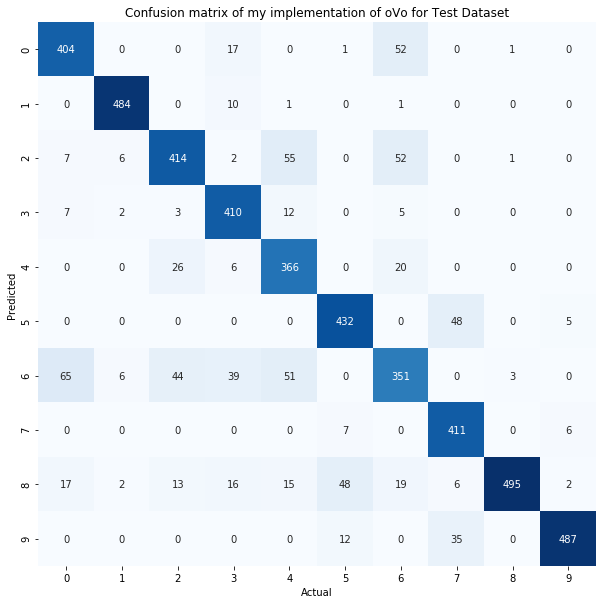

In [0]:
metrics.confusion_matrix(Y_test_whole, pred_test_my, title='Confusion matrix of my implementation of oVo for Test Dataset')

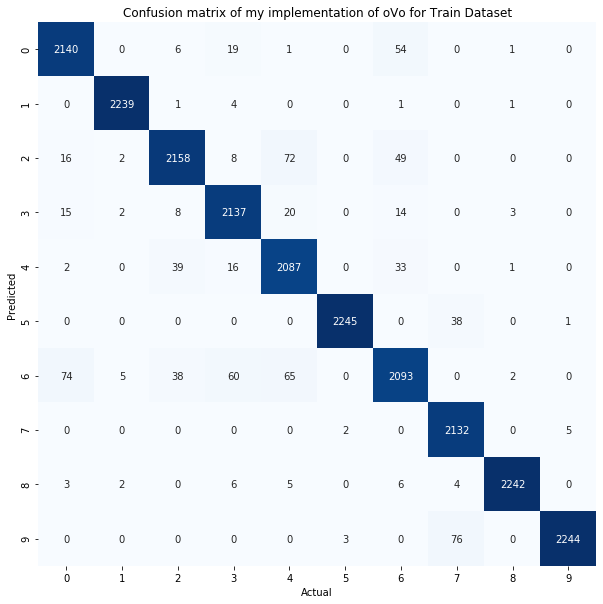

In [0]:
metrics.confusion_matrix(Y_train_whole, pred_train_my, title='Confusion matrix of my implementation of oVo for Train Dataset')

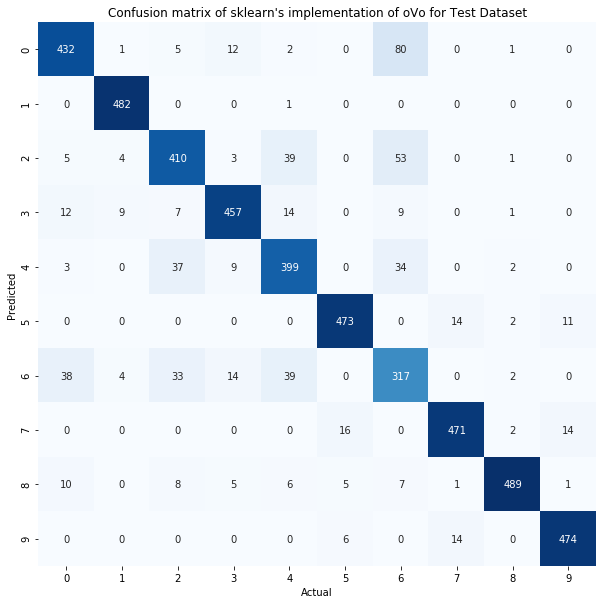

In [0]:
metrics.confusion_matrix(Y_test_whole, pred_test_sk, title='Confusion matrix of sklearn\'s implementation of oVo for Test Dataset')

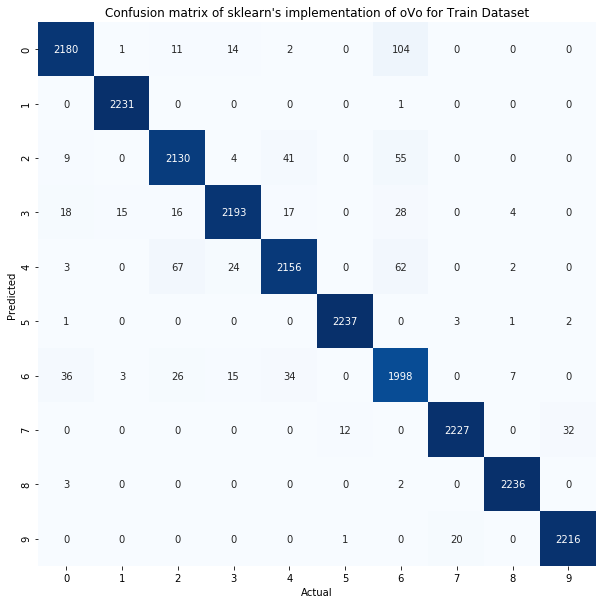

In [0]:
metrics.confusion_matrix(Y_train_whole, pred_train_sk, title='Confusion matrix of sklearn\'s implementation of oVo for Train Dataset')

* **Observations :**

    * Here we can see that all diagonal enries are large hence we can say that our model performed well as true poitives are large for all the classes.

    * 1. Here we can see that (6,0) has the large value and that is expected as class 0 is T-shirt/top and 6 is shirt.
  2. (6,2) also has large value and 2=pullover and 6=shirt hance justified.
  3. (6,4) also has large value and 4=coat and 6=shirt hance justified.
  4. (2,4) also has large value and 2=pullover and 4=coat hance justified.
  5. (7,8) also has large value and 7=sneaker and 9=Ankle boot justified.
  
      Hence we can see that those classes which are similar are mostly misclassified between each other.

## Part (d): k-fold Cross Validation

* In this part I have performed GridSearchCV to perform 5-fold cross validation on C=[1e-5, 1e-3, 1, 5, 10]. And then plotted average validation and average train accuracies along with test accuracy for each C. 

In [0]:
from sklearn.model_selection import GridSearchCV

#Performing 5-fold Cross validation
t0=time()
C_lst = [10**-5,10**-3,1,5,10]
gscv = GridSearchCV(SVC(kernel='rbf', gamma=0.05, decision_function_shape='ovo'), {'C':C_lst}, cv=5, return_train_score=True, n_jobs=-1)

gscv.fit(train[:,:-1]/255, train[:,-1].ravel())

print('Cross Validation completed in %d minutes'%((time()-t0)/60))

Cross Validation completed in 37 minutes


In [0]:
def get_test_accuracy(c, X_train, Y_train, X_test, Y_test):
    '''
        Helper method that will be used in parallelization to find test accuracy on 5 models corrosponding to each C
    '''
    clf = SVC(C=c,kernel='rbf', gamma=0.05, decision_function_shape='ovo')
    clf.fit(X_train, Y_train)
    return clf.score(X_test, Y_test)

#Getting test accuracies
test_score = Parallel(n_jobs=5)(delayed(get_test_accuracy)(c, train[:,:-1]/255, train[:,-1].ravel(), test[:,:-1]/255, test[:,-1].ravel()) for c in C_lst)

In [0]:
#Printing the best estimator
print(gscv.best_estimator_)

SVC(C=5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma=0.05, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


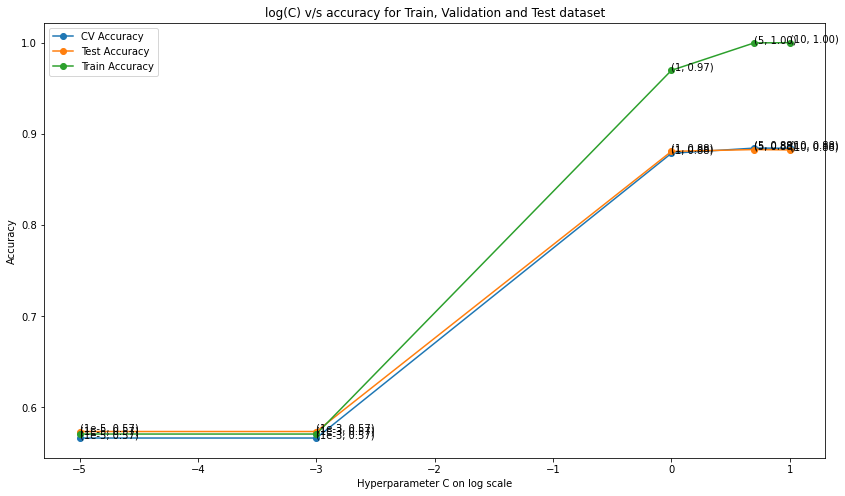

In [0]:
#plotting train, validation and test accuracies

plt.figure(figsize=(14,8))
cv_score = gscv.cv_results_['mean_test_score']
train_score = gscv.cv_results_['mean_train_score']
plt.plot(np.log10(C_lst), cv_score, label='CV Accuracy',  marker='o')
plt.plot(np.log10(C_lst), test_score, label='Test Accuracy', marker='o')
plt.plot(np.log10(C_lst), train_score, label='Train Accuracy', marker='o')
for i_x, i_y, c in zip(np.log10(C_lst), cv_score,['1e-5', '1e-3', '1', '5', '10']):
    plt.text(i_x, i_y, '(%s, %.2f)'%(c, i_y))
for i_x, i_y, c in zip(np.log10(C_lst), train_score,['1e-5', '1e-3', '1', '5', '10']):
    plt.text(i_x, i_y, '(%s, %.2f)'%(c, i_y))
for i_x, i_y, c in zip(np.log10(C_lst), test_score,['1e-5', '1e-3', '1', '5', '10']):
    plt.text(i_x, i_y, '(%s, %.2f)'%(c, i_y))
plt.legend()
plt.title('log(C) v/s accuracy for Train, Validation and Test dataset')
plt.xlabel('Hyperparameter C on log scale')
plt.ylabel('Accuracy')
plt.show()

In [0]:
print('Hyperparameter C : ', C_lst)
print('Train Score : ', train_score.tolist())
print('Test Score : ', test_score)
print('Validation Score : ', cv_score.tolist())

Hyperparameter C :  [1e-05, 0.001, 1, 5, 10]
Train Score :  [0.5708222222222222, 0.5708222222222222, 0.9696555555555557, 0.9997555555555555, 1.0]
Validation Score :  [0.5664444444444444, 0.5664444444444444, 0.8787111111111111, 0.8844, 0.8842666666666666]
Test Score :  [0.5736, 0.5736, 0.8808, 0.8828, 0.8824]


* **Observations :**
    * Here we got C=5 as best C as we got validation accuracy for C=5 of 88.44%
    * In below table I have summarized train, validation and test accuracies for all 5 values of C. And these are some observations from that table
        * Here We can see that we get the best test accuracy for C=5
        * Here we can also see ine interesting trend that as C increases accuracies tend to increase and for C=10 we have train accuracy of 100%. Hence we might be overfitting. This is in line with our intuition that as C increases chances of overfitting increases and as C decreases chances of underfitting increases

|                            | C=1e-5  | C=1e-3  | C=1     | C=5     | C=10    |
|----------------------------|---------|---------|---------|---------|---------|
| Train Accuracy (in %)      | 57.0822 | 57.0822 | 96.9656 | 99.9756 | 100     |
| Validation Accuracy (in %) | 56.6444 | 56.6444 | 87.8711 | 88.44   | 88.4267 |
| Test Accuracy (in %)       | 57.36   | 57.36   | 88.08   | 88.28   | 88.24   |
    